In [36]:
import torch
import logging
import statistics
import numpy as np
import src.clip as clip
from torchinfo import summary
import matplotlib.pyplot as plt
import torchvision.transforms as T
from accelerate import Accelerator
from yacs.config import CfgNode as CN
from main import get_config, init_accelerator, set_seed, FFPP
from src.models import Detector
logging.basicConfig(level="DEBUG")


class Obj:
    pass


c = FFPP.get_default_config()
# c.augmentation = "normal+frame"
# c.augmentation = "none"
c.random_speed = 0
c.pair = 1
c.compressions = ["c23"]
# c.types = ["REAL", "NT", "DF", "FS", "F2F"]
c.types = ["NT", "DF", "FS", "F2F"]
# c.types = ["REAL"]


mc = Detector.get_default_config()
mc.out_dim = [2]
mc.adapter = CN()
mc.adapter.frozen = 0
mc.adapter.struct = CN()
# mc.adapter.struct.type = "legacy-768-x-768"
mc.adapter.struct.type = "768-x-768-nln"
mc.adapter.struct.x = 256
mc.adapter.type = "normal"

accelerator = Accelerator(mixed_precision='no')
model = Detector(mc, 20, accelerator).to(accelerator.device).eval()
model.to("cuda")
# encoder = clip.load("ViT-B/16")[0].visual.float()
encoder = model.encoder
# adapter = model.adapter
# adapter.load_state_dict(
#     {
#         k[8:]: v for k, v in
#         torch.load(
#             # "/home/od/Desktop/repos/dfd-clip/logs/comp-inv/comp-inv/mode1+256+resi+1e-2/last_weights.pt",
#             "/home/od/Desktop/repos/dfd-clip/logs/test/0520T1305/best_weights.pt",
#             map_location="cpu"
#         ).items()
#         if "adapter" in k
#     }
# )


transform = model.transform
n_px = 224
frames = 20
seconds = 1

x = FFPP(c.clone(), frames, seconds, transform, accelerator, split="train")
_x = FFPP(
    c.clone(),
    frames,
    seconds,
    T.Compose([
              T.Resize(n_px, interpolation=T.InterpolationMode.BICUBIC),
              T.CenterCrop(n_px),
              T.ConvertImageDtype(torch.float32)
              ]),
    accelerator,
    split="train"
)

INFO:root:Adapter operates without pretrained weights!!!
F2F: c23/videos: 100%|██████████| 4/4 [00:00<00:00, 742.55it/s]


In [37]:
print(c)
print(len(x))

augmentation: none
category: train
compressions: ['c23']
contrast: 0
detection_level: video
name: FFPP
pack: 0
pair: 1
random_speed: 0
root_dir: ./datasets/ffpp/
scale: 1.0
ssl_fake: 0
types: ['NT', 'DF', 'FS', 'F2F']
vid_ext: .avi
46980


In [ ]:
import random
idx = random.randint(0, len(x))
# idx = 5437
# idx = 1470
# idx = 27392
data = x[idx]
_data = _x[idx]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig_scale = 3
plt.figure(figsize=(frames * fig_scale, 2 * fig_scale))
for i, q in enumerate(["raw", "c23"]):
    d = _data[0][q].numpy().transpose((0, 2, 3, 1))
    for j, f in enumerate(d):
        plt.subplot(2, frames, i * frames + j + 1)
        plt.imshow(f)
        plt.gca().set_yticks([i for i in range(n_px) if i % 16 == 0])
        plt.gca().set_xticks([i for i in range(n_px) if i % 16 == 0])
        plt.gca().xaxis.set_tick_params(labelbottom=False)
        plt.gca().yaxis.set_tick_params(labelleft=False)
        plt.grid(True, alpha=0.5)

In [ ]:
features = {}
# nfeatures = {}
with torch.no_grad():
    for k, imgs in data[0].items():
        # get key and value from each CLIP ViT layer
        kvs = encoder(imgs.to("cuda"), with_out=True, with_q=True)
        # discard original CLS token and restore temporal dimension
        kvs = [{k: v[:, 1:] for k, v in kv.items()} for kv in kvs]
        kvs = [{k: v.view(*v.shape[:2], 768).to("cpu") for k, v in kv.items()} for kv in kvs]
        features[k] = kvs
torch.cuda.empty_cache()

In [ ]:
# b = torch.max(
#     torch.abs(
#         (features["c23"][0]["k"] - torch.mean(features["c23"][0]["k"], dim=0)) /
#         torch.var(features["c23"][0]["k"], dim=0)
#     ).mean(dim=-1),
#     dim=0
# )[0]
# features["raw"][0]["k"].shape, features["raw"][0]["k"][0, 14 * 4 + 4].shape
# torch.nn.functional.cosine_similarity(
#     features["raw"][0]["k"],
#     features["raw"][0]["k"][0, 14 * 4 + 4],
#     dim=-1
# ).mean(dim=0)

In [ ]:
# # This scenario shows the distribution of each subject(k,v,out)
# # throughout the temporal dimension of each ViT layer
# methods = {}
# for m in ["raw", "c23"]:
#     l = {
#         "k": [],
#         "v": [],
#         "out": []
#     }
#     for l2 in range(12):
#         for subject in ["k", "v", "out"]:
#             l[subject].append(
#                 torch.var(features[m][l2][subject], dim=0).mean(dim=-1).view((14, 14))
#                 # torch.max(
#                 #     torch.abs(
#                 #         (features[m][l2][subject] - torch.mean(features[m][l2][subject], dim=0)) /
#                 #         torch.sqrt(torch.var(features[m][l2][subject], dim=0))
#                 #     ).mean(dim=-1),
#                 #     dim=0
#                 # )[0].view(14, 14)
#             )
#     methods[m] = l


# for name, l in methods.items():
#     plt.figure(figsize=(36, 9), layout="constrained")
#     plt.suptitle(f'{name}', fontsize=12)
#     for j, s in enumerate(["k", "v", "out"]):
#         for i, v in enumerate(l[s]):
#             plt.subplot(3, 12, j * 12 + i + 1)
#             im = plt.imshow(v)

#             # Show all ticks and label them with the respective list entries
#             plt.gca().set_xticks(np.arange(14))
#             plt.gca().set_yticks(np.arange(14))

#     plt.tight_layout()
#     plt.show()

In [ ]:
# # This scenario shows the layer-specific similarity given a patch location of the
# # first frame and all video patches. The result is an temporally averaged value for each patch location.
# methods = {}
# for m in ["raw", "c23"]:
#     l = {
#         "k": [],
#         "v": [],
#         "out": []
#     }
#     for l2 in range(12):
#         for subject in ["k", "v", "out"]:
#             l[subject].append(
#                 torch.nn.functional.cosine_similarity(
#                     features[m][l2][subject],
#                     features[m][l2][subject][0, 14 * 7 + 7],
#                     dim=-1
#                 ).mean(dim=0).view((14, 14))
#             )
#     methods[m] = l


# for name, l in methods.items():
#     plt.figure(figsize=(36, 9), layout="constrained")
#     plt.suptitle(f'{name}', fontsize=12)
#     for j, s in enumerate(["k", "v", "out"]):
#         for i, v in enumerate(l[s]):
#             plt.subplot(3, 12, j * 12 + i + 1)
#             im = plt.imshow(v)

#             # Show all ticks and label them with the respective list entries
#             plt.gca().set_xticks(np.arange(14))
#             plt.gca().set_yticks(np.arange(14))

#     plt.tight_layout()
#     plt.show()

In [ ]:
# This scenario shows the similarity given a patch location of the first frame and all video patches.
# The result is an temporally averaged value for each patch location.
methods = {}
subjects = ['q', 'k', 'v', 'out']
# qualities = ["raw", "c23"]
# subjects = ['k']
qualities = ["c23"]
for m in qualities:
    l = {
        s: []
        for s in subjects
    }
    for l2 in range(12):
        for subject in subjects:
            l[subject].append(
                (torch.nn.functional.cosine_similarity(
                    features[m][l2][subject],
                    features[m][l2][subject][0, 14 * 0 + 6],
                    dim=-1
                ) / 768).softmax(dim=-1).view((-1, 14, 14)).permute(1, 0, 2).flatten(1, 2)
            )
    methods[m] = l


for name, l in methods.items():
    for _, s in enumerate(subjects):
        plt.figure(figsize=(60, 36), layout="constrained")
        plt.suptitle(f'{name}-{s}', fontsize=12)
        for j in range(12):
            plt.subplot(12, 1, j + 1)

            im = plt.imshow(l[s][j])
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]DEBUG:root:Item/Video Index:21185/1282
DEBUG:root:Item DF/COMP:FS/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/FS/raw/videos/068_028.avi
DEBUG:root:Sample Offset: 12
DEBUG:root:Sample Stride: 0.050877192982456146
DEBUG:root:Augmentations Applied.
DEBUG:root:Video: ./datasets/ffpp/FS/raw/videos/068_028.avi, Completed!
DEBUG:root:Loading Video: ./datasets/ffpp/FS/c23/videos/068_028.avi
DEBUG:root:Sample Offset: 12
DEBUG:root:Sample Stride: 0.050877192982456146
DEBUG:root:Augmentations Applied.
DEBUG:root:Video: ./datasets/ffpp/FS/c23/videos/068_028.avi, Completed!
  5%|▌         | 1/20 [00:00<00:13,  1.46it/s]DEBUG:root:Item/Video Index:34973/2217
DEBUG:root:Item DF/COMP:F2F/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/F2F/raw/videos/984_967.avi
DEBUG:root:Sample Offset: 11
DEBUG:root:Sample Stride: 0.050

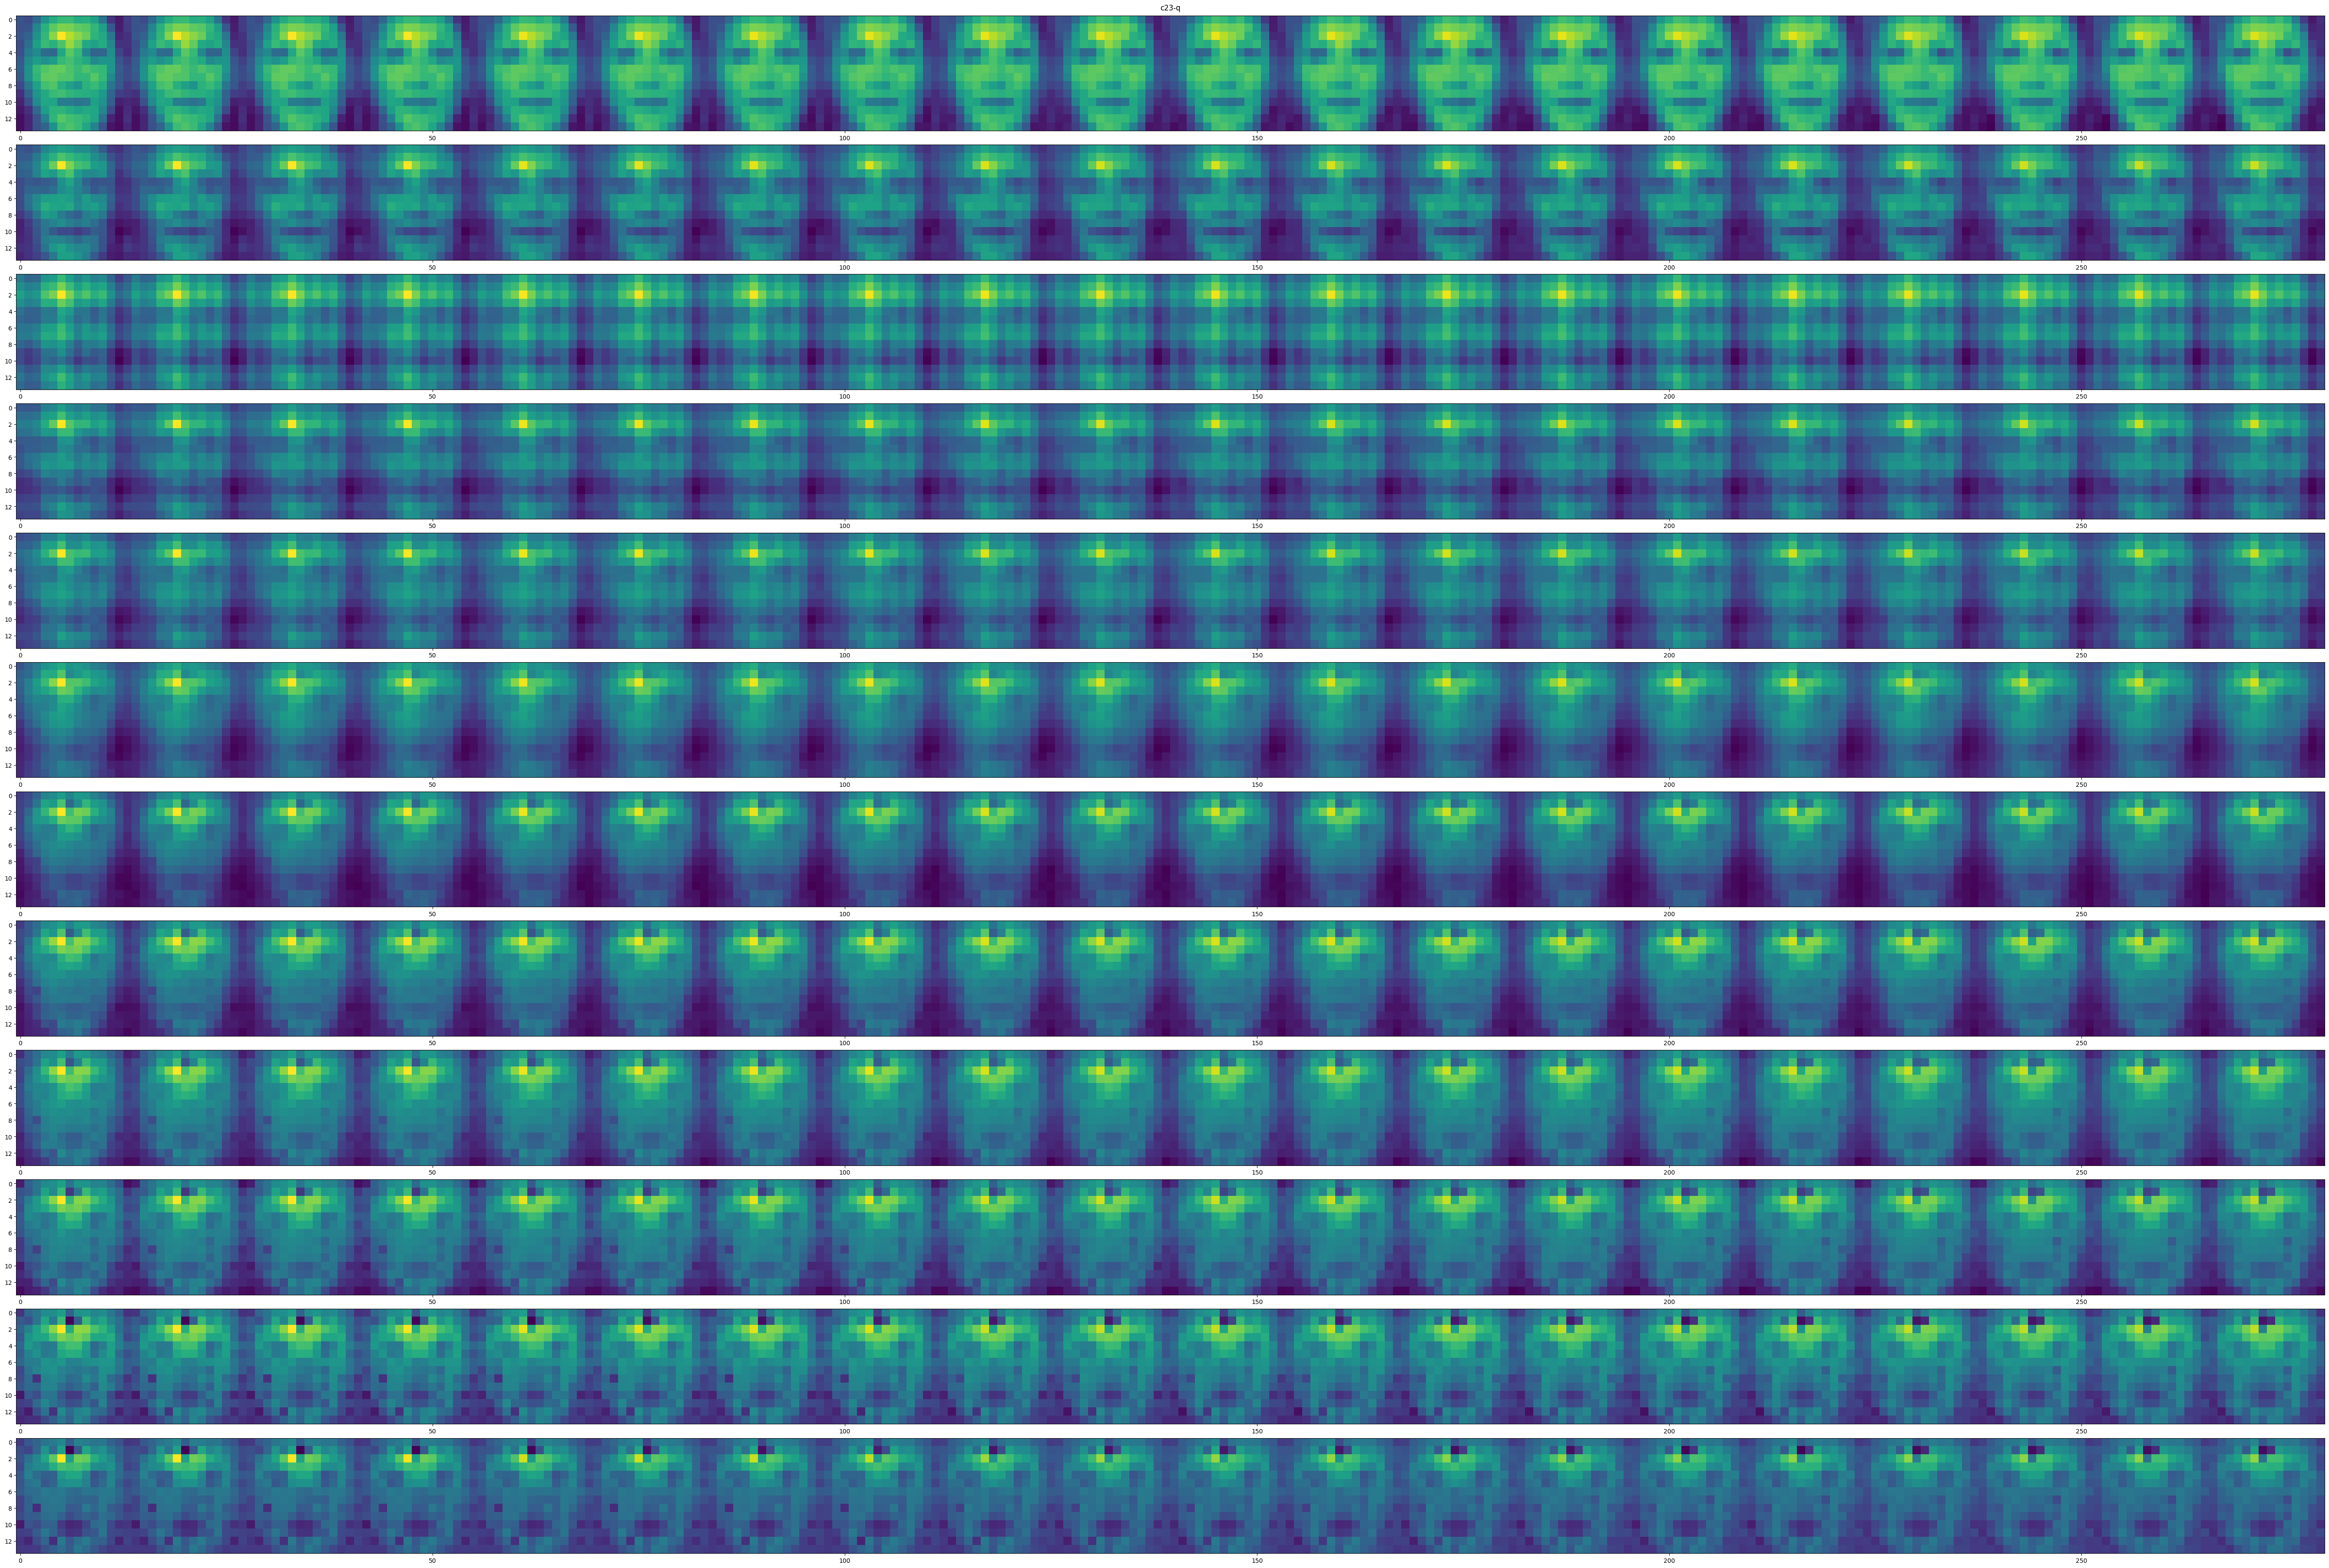

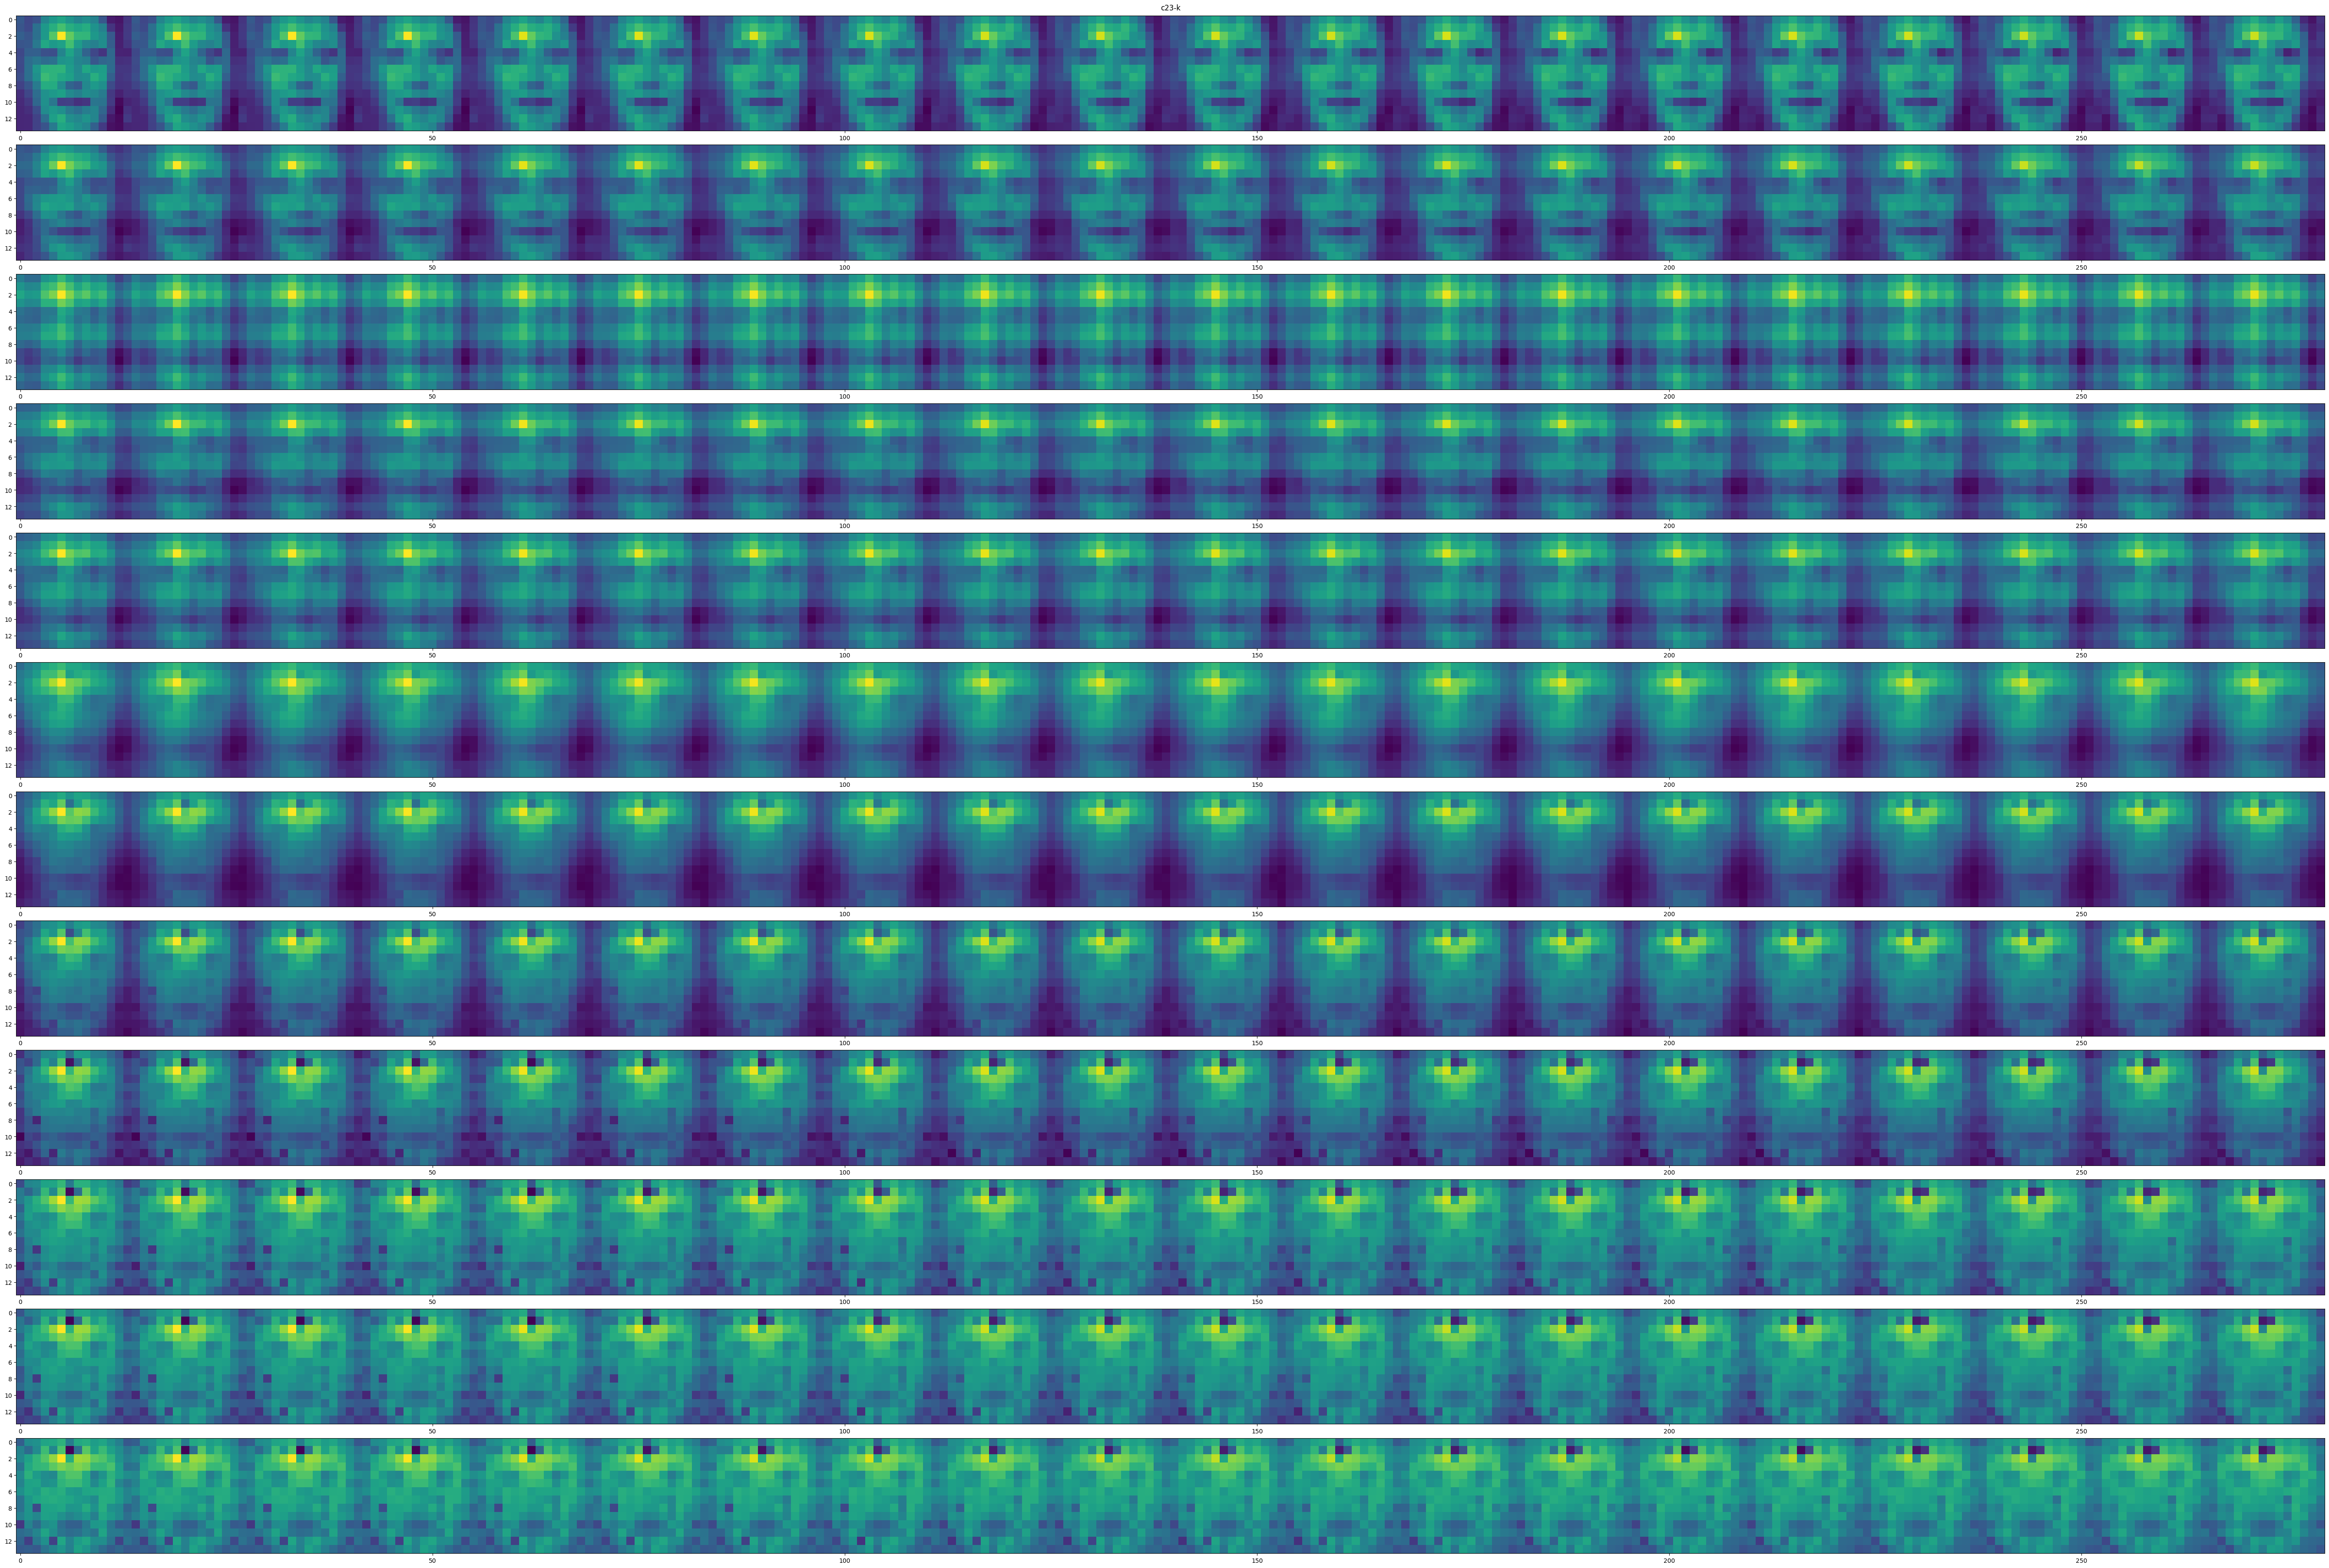

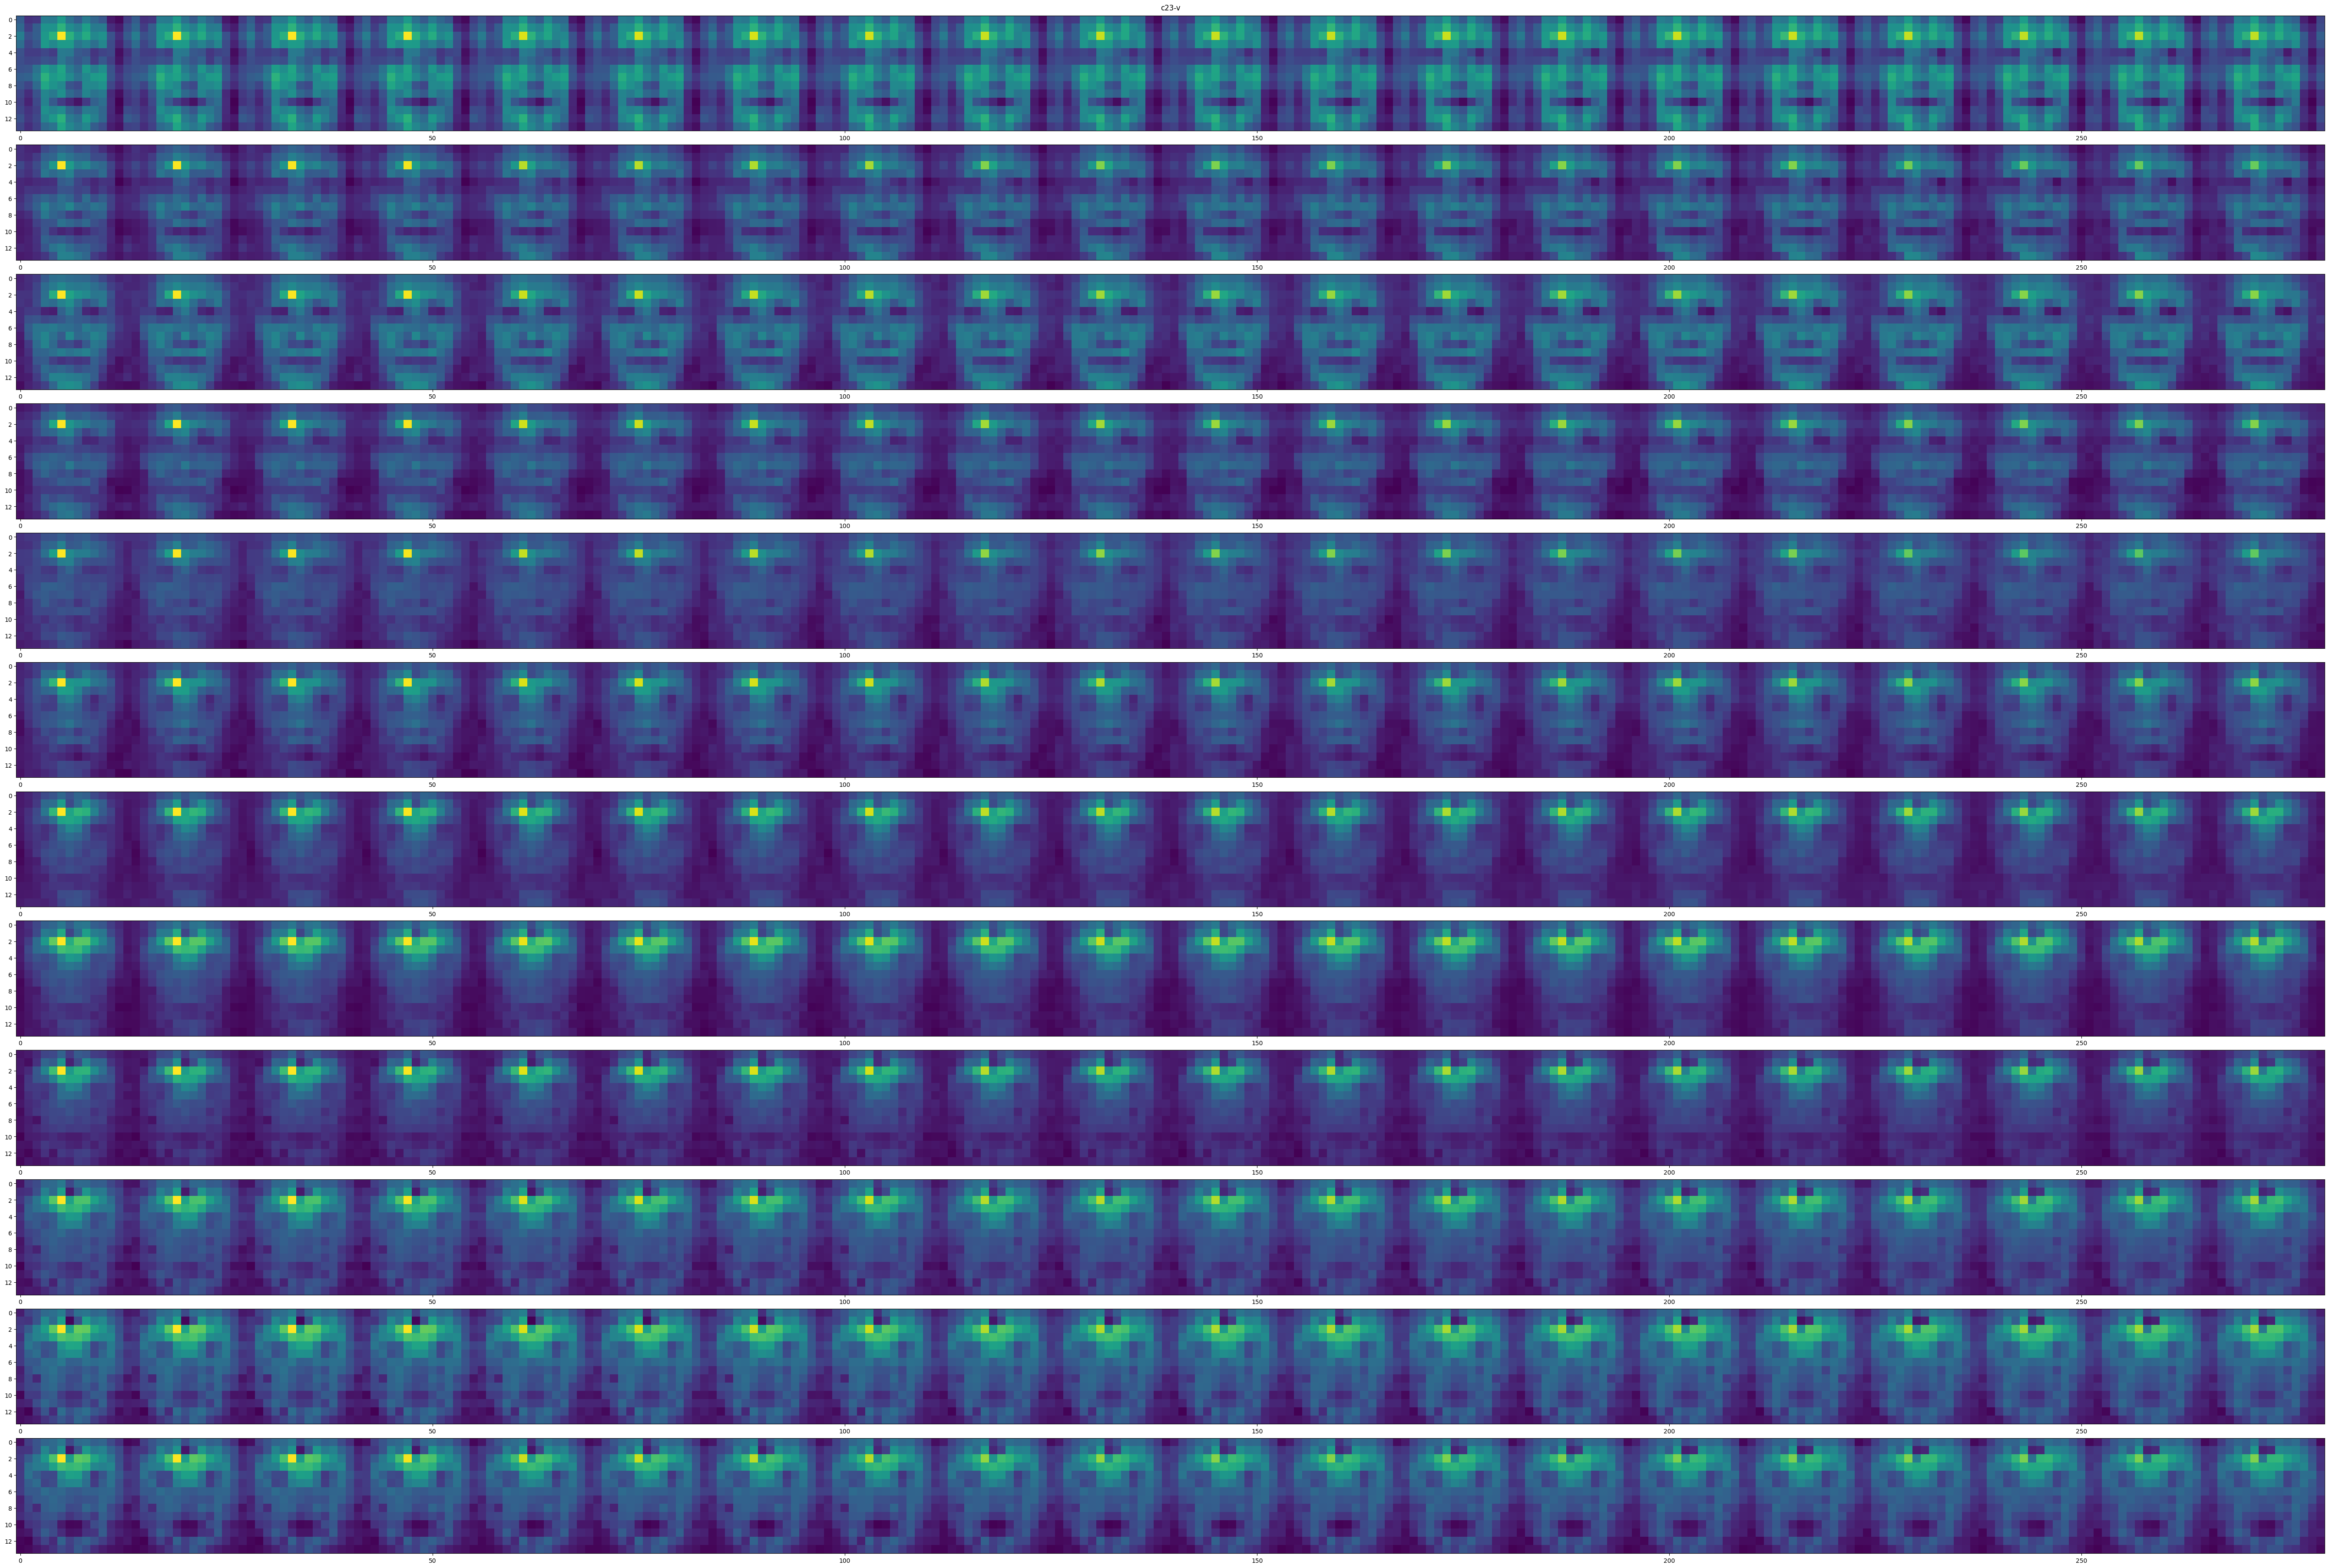

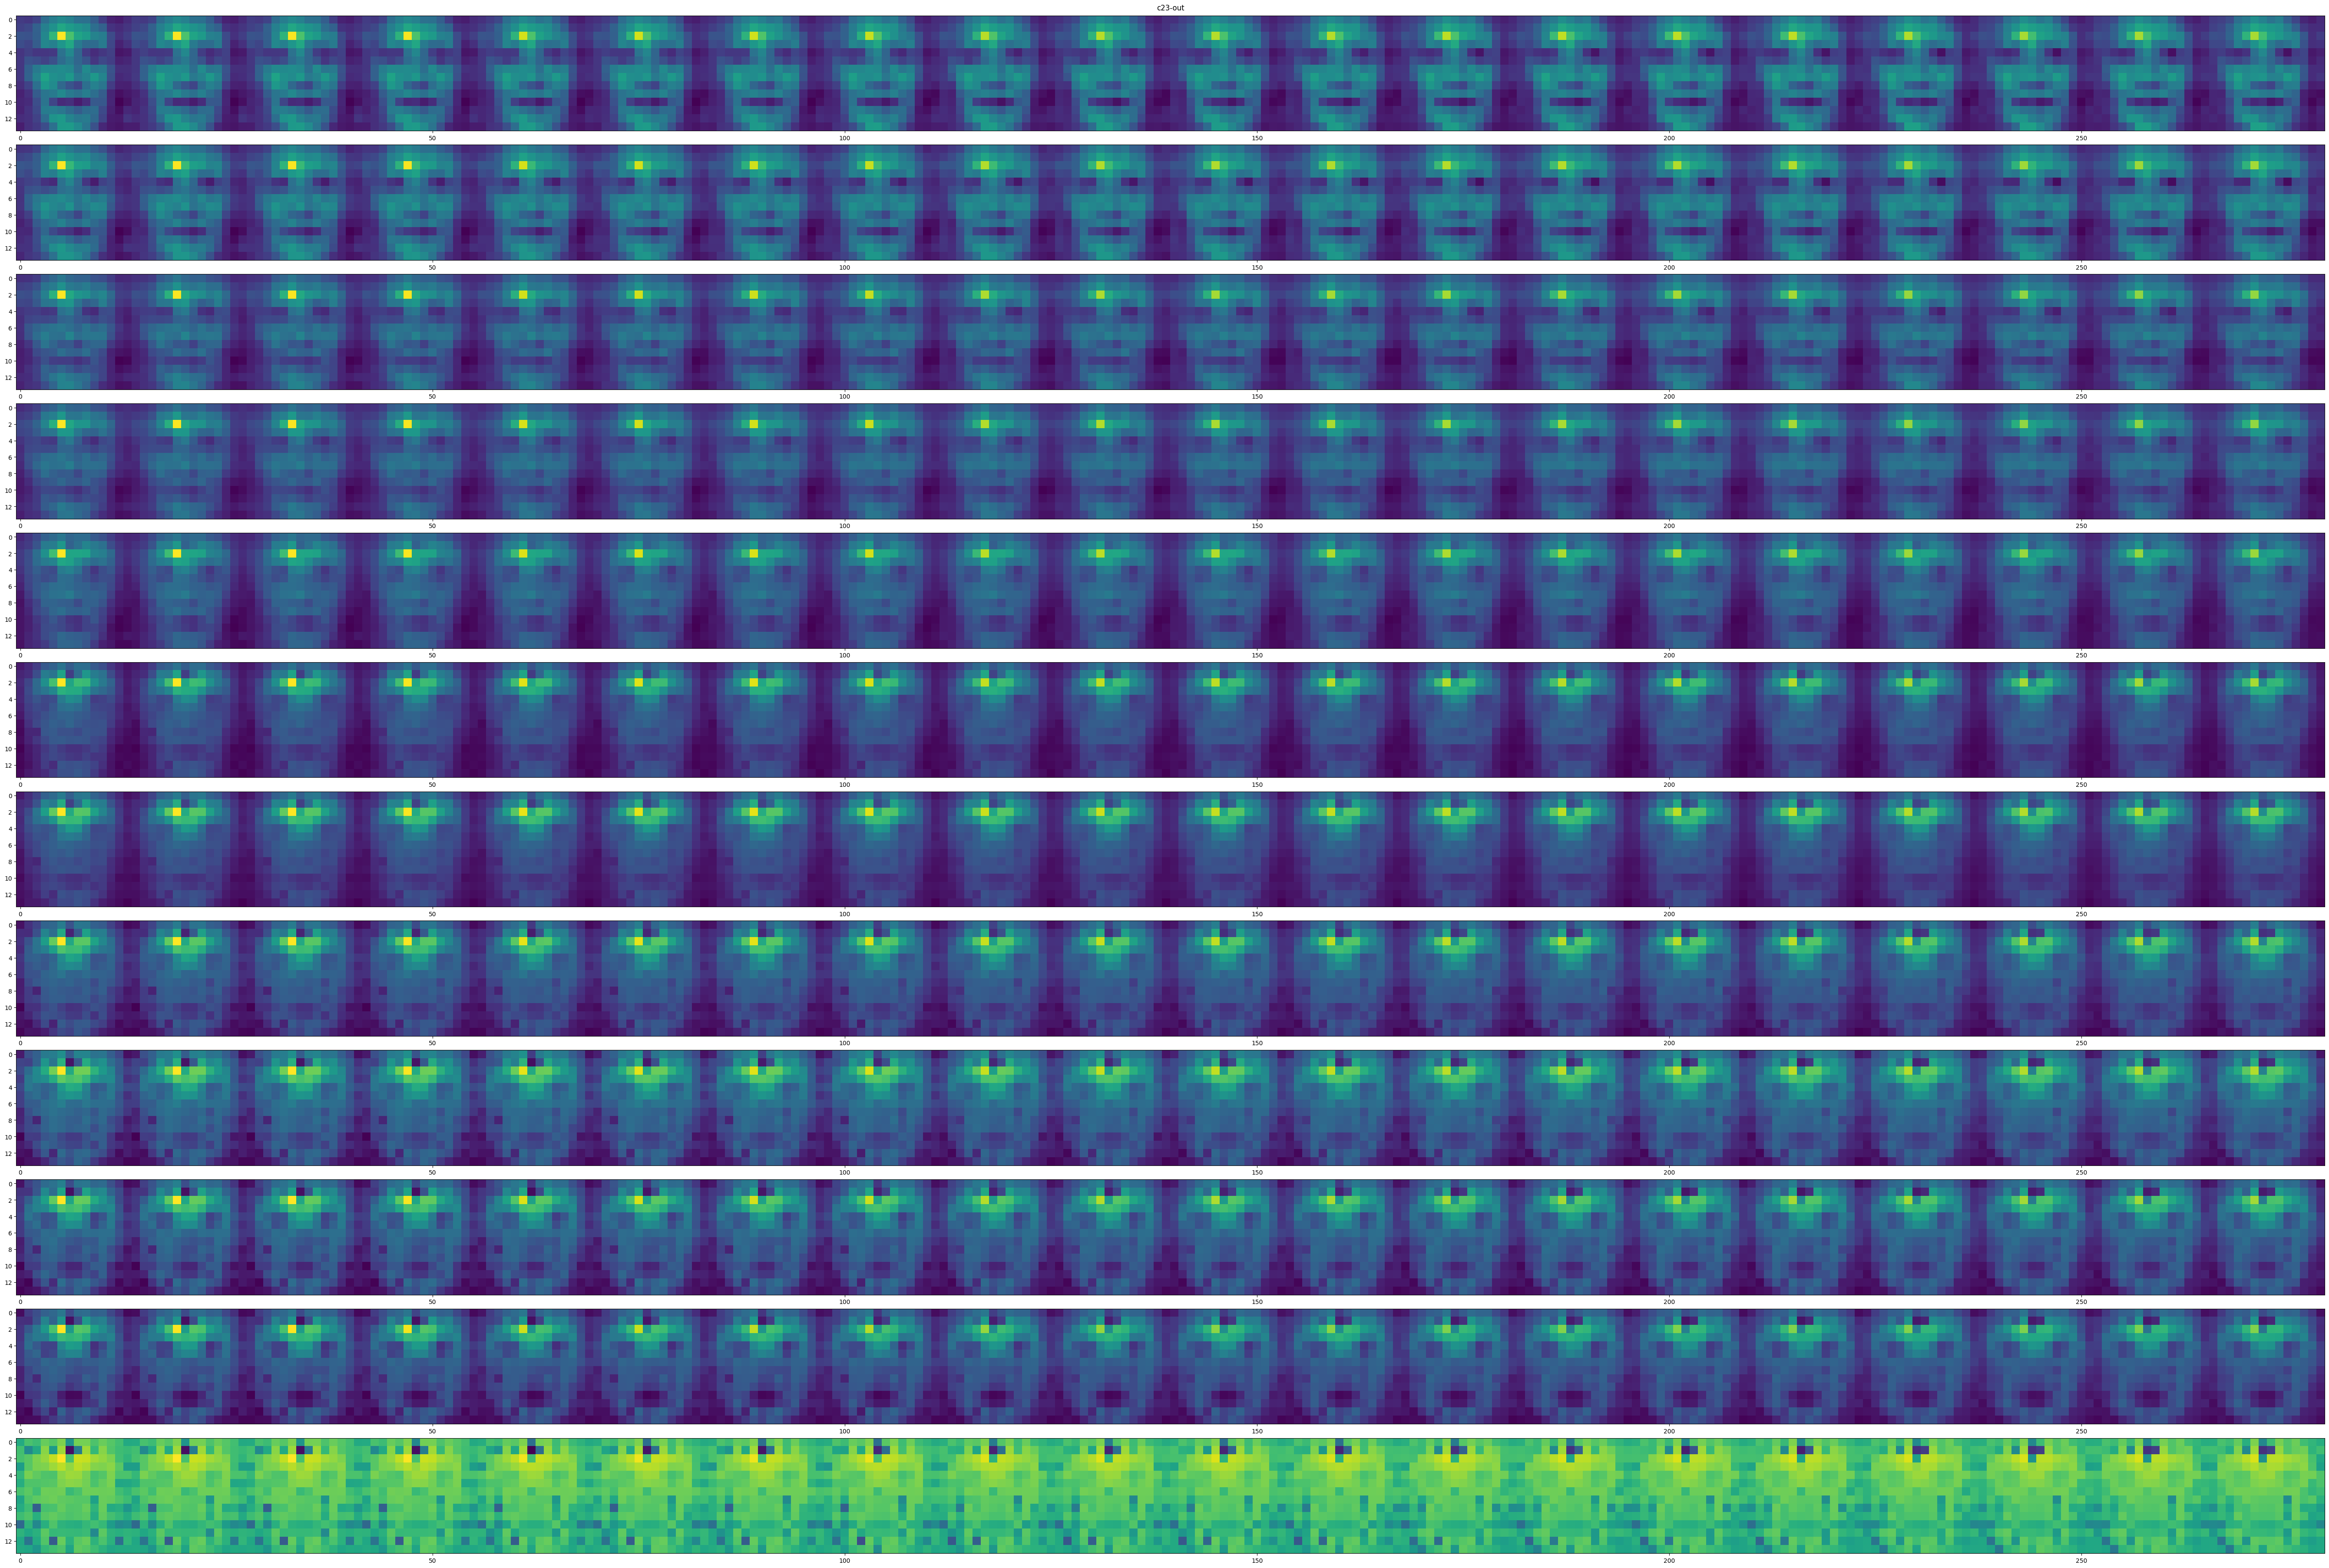

In [38]:
# This scenario shows the similarity given a patch location of the first frame and all video patches.
# The result is an temporally averaged value for each patch location.
import random
from tqdm import tqdm

subjects = ['q', 'k', 'v', 'out']
# qualities = ["raw", "c23"]
# subjects = ['k']
qualities = ["c23"]

methods = {
    q: {
        s: [torch.zeros((14, frames * 14)) for _ in range(12)]
        for s in subjects
    } for q in qualities
}

for i in tqdm(range(20)):
    ########## random select index ############
    idx = random.randint(0, len(x))
    data = x[idx]

    ######### extract video features ###########
    features = {}
    with torch.no_grad():
        for k, imgs in data[0].items():
            # get key and value from each CLIP ViT layer
            kvs = encoder(imgs.to("cuda"), with_out=True, with_q=True)
            # discard original CLS token and restore temporal dimension
            kvs = [{k: v[:, 1:] for k, v in kv.items()} for kv in kvs]
            kvs = [{k: v.view(*v.shape[:2], 768).to("cpu") for k, v in kv.items()} for kv in kvs]
            features[k] = kvs
    torch.cuda.empty_cache()

    ######### extract video features ###########
    for m in qualities:
        for l2 in range(12):
            for subject in subjects:
                methods[m][subject][l2] += (torch.nn.functional.cosine_similarity(
                    features[m][l2][subject],
                    features[m][l2][subject][0, 14 * 2 + 5],
                    dim=-1
                ) / (768**0.5)).softmax(dim=-1).view((-1, 14, 14)).permute(1, 0, 2).flatten(1, 2) / 100


for name, l in methods.items():
    for _, s in enumerate(subjects):
        plt.figure(figsize=(60, 36), layout="constrained")
        plt.suptitle(f'{name}-{s}', fontsize=12)
        for j in range(12):
            plt.subplot(12, 1, j + 1)

            im = plt.imshow(l[s][j])
    plt.show()